## Model description

We study the steam governor system described in [1]. It is a continuous system defined by the following ODE.

$$
   \left\{  \begin{array}{lcl}  \dot{x} & = & y \\  \dot{y} & = & z^2 \cdot \sin(x) \cdot \cos(x) - \sin(x) - \epsilon\cdot y \\  \dot{z} & = & \alpha \cdot (\cos(x) - \beta)  \end{array}  \right.
$$

wherein  $\epsilon$,  $\alpha$  and $\beta$  are constants. It is proved in [1] that the system has an asymptotically stable equilibrium when $\epsilon > 2\cdot \alpha \cdot \beta^{\frac{3}{2}}$.

The numerical values for the model's constants are given in the following table, and are taken from the HyPro benchmarks [1].

|Quantity |Value  |
|:---------|-------|
|$\epsilon$       | 3.0   |
|$\alpha$        | 1.0   |
|$\beta$        | 1.0   |

In [1]:
using Reachability, MathematicalSystems, TaylorIntegration

[1] https://ths.rwth-aachen.de/research/projects/hypro/steam-governor/

[2] J. Sotomayor, L. Mello, D. Braga. *Bifurcation analysis of the Watt governor system.* Computational & Applied Mathematics, Vol. 26, No. 1, pages 19-44, SBMAC, 2007.

In [2]:
@taylorize function steam_governor!(du, u, p, t)
    local ϵ = 3.0
    local α = 1.0
    local β = 1.0

    du[1] = u[2]
    du[2] = u[3]^2 * sin(u[1]) * cos(u[1]) - sin(u[1]) - ϵ*u[2]
    du[3] = α*(cos(u[1]) - β)

    return du
end

## Reachability settings

We consider the initial set $x\in [0.9, 1.1]$,  $y \in [-0.1, 0.1]$,  $z \in [0.9, 1.1]$.

These settings are taken from the HyPro benchmarks [1].

In [3]:
x₀ = Interval(0.9, 1.1)
y₀ = Interval(-0.1, 0.1)
z₀ = Interval(0.9, 1.1)

X₀ = x₀ × y₀ × z₀;

In [5]:
S = BlackBoxContinuousSystem(steam_governor!, 3)
P = InitialValueProblem(S, X₀);

## Results

Next we compute an overapproximation of the flowpipe using the TMJets algorithm for the time horizon $[0, 10]$.

In [6]:
sol = solve(P, Options(:T=>10.0),
            op=TMJets(Options(:max_steps=>1_000, :abs_tol=>1e-10, :orderT=>6, :orderQ=>2,:output_type=>Zonotope)));

In [12]:
using Plots

Since the flowpipe is three-dimensional, we have to project it for 2D plotting. We project onto dimensions $x$ and $y$:

In [23]:
πsol = Vector{Hyperrectangle{Float64, Vector{Float64}, Vector{Float64}}}()
for s in sol.Xk
    πs = project(set(s), [1, 2], LazySets.LinearMap)
    oπs = overapproximate(πs, Hyperrectangle)
    push!(πsol, oπs)
end
typeof(πsol), length(πsol)

(Array{Hyperrectangle{Float64,Array{Float64,1},Array{Float64,1}},1}, 189)

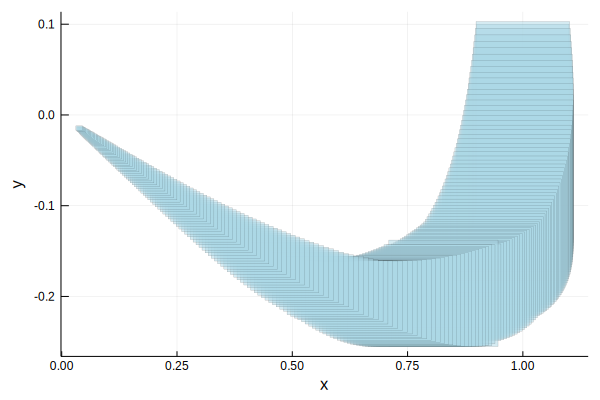

In [24]:
plot(πsol, xlab="x", ylab="y", lw=0.2, color=:lightblue, lab="")

Since the flowpipe has been approximated with zonotopes, we can as well project the zonotopes by taking a (concrete) linear map. Consider the following projection matrix onto the first two variables:

In [25]:
using SparseArrays

M = sparse([1, 2], [1, 2], [1.0, 1.0], 2, 3)
Matrix(M)

2×3 Array{Float64,2}:
 1.0  0.0  0.0
 0.0  1.0  0.0

Then, we apply the projection $M$ to each set of the flowpipe: 

In [26]:
πsol = Vector{Zonotope{Float64}}()
for s in sol.Xk
    πs = linear_map(M, set(s))
    push!(πsol, πs)
end
typeof(πsol), length(πsol)

(Array{Zonotope{Float64},1}, 189)

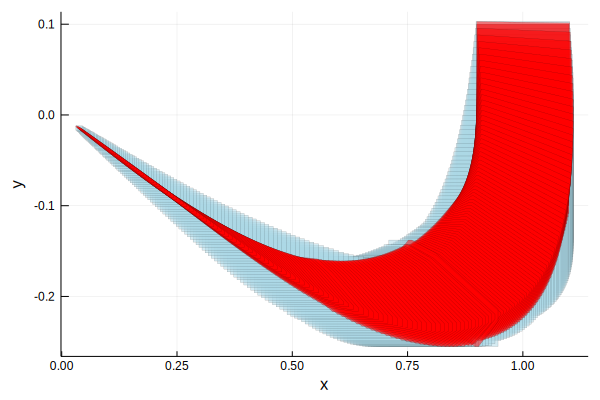

In [27]:
plot!(πsol, xlab="x", ylab="y", lw=0.2, color=:red, lab="")

The red flowpipe obtained with the second approach is more precision, since there is no overapproximation in the projection.